**VGG19 implementation in Keras:**

Based on the paper Deep Residual Learning for Image Recognition

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model


In [20]:
class BasicBlock(Model):
    def __init__(self, filters, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()

        if stride != 1:
            self.shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)
        else:
            self.shortcut = lambda x: x

    def call(self, x, training=False):
        residual = self.shortcut(x)

        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        x += residual
        x = tf.nn.relu(x)

        return x

In [21]:
class ResNet18(Model):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.conv1 = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')
        self.stage1 = self._make_layer(64, num_blocks=2, stride=1)
        self.stage2 = self._make_layer(128, num_blocks=2, stride=2)
        self.stage3 = self._make_layer(256, num_blocks=2, stride=2)
        self.stage4 = self._make_layer(512, num_blocks=2, stride=2)

        self.global_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def _make_layer(self, filters, num_blocks, stride):
        layers_list = []
        layers_list.append(BasicBlock(filters, stride))
        for _ in range(1, num_blocks):
            layers_list.append(BasicBlock(filters, stride=1))
        return tf.keras.Sequential(layers_list)

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.stage1(x, training=training)
        x = self.stage2(x, training=training)
        x = self.stage3(x, training=training)
        x = self.stage4(x, training=training)

        x = self.global_pool(x)
        x = self.fc(x)

        return x


In [22]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [23]:
num_classes = 10
model = ResNet18(num_classes)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [24]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=64)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.4089 - loss: 1.7249 - val_accuracy: 0.4633 - val_loss: 1.6001
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6217 - loss: 1.0757 - val_accuracy: 0.4912 - val_loss: 1.5856
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6991 - loss: 0.8647 - val_accuracy: 0.6257 - val_loss: 1.1099
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7401 - loss: 0.7526 - val_accuracy: 0.5837 - val_loss: 1.3189
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7703 - loss: 0.6543 - val_accuracy: 0.6105 - val_loss: 1.2752
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8080 - loss: 0.5577 - val_accuracy: 0.6738 - val_loss: 1.0271
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8372 - loss: 0.4720 - val_accuracy: 0.6968 - val_loss: 0.9283
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8618 - loss: 0.3956 - 

In [25]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7335 - loss: 1.3141
Test accuracy: 0.7313


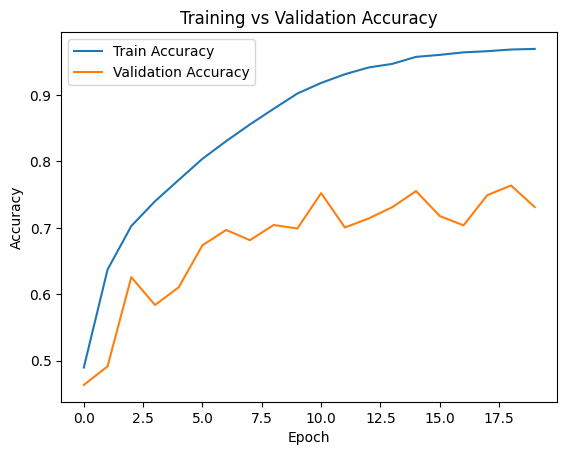

In [26]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()